# Stock Price Prediction for SENSEX for year 2020 using LSTM Model
#### Dataset contains historical data for sensex from 1 Jan 2010 to 31 Dec 2020

In [1]:
#pip install investpy

In [2]:
#importing required libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import investpy
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

Reading csv file into a dataframe

In [3]:
#below command can be used to get list of countries
#investpy.get_stock_countries()

In [4]:
#below command can be used to get list of stocks available
#stocks_list = investpy.get_stocks_list(country='India')

In [5]:
#extract data for SBI from 1 Jan 2010 to 31 Dec 2020
df = investpy.get_stock_historical_data(stock='SBI',
                                        country='india',
                                        from_date='01/01/2010',
                                        to_date='31/12/2020')

In [6]:
df.head()

,Open,High,Low,Close,Volume,Currency
Date,,,,,,
2010-01-04,227.5,230.00,227.50,229.12,11031470,INR
2010-01-05,230.8,231.00,228.01,229.21,11613740,INR
2010-01-06,229.7,231.50,228.50,230.58,14527930,INR
2010-01-07,230.6,231.00,228.11,229.29,8576510,INR
2010-01-08,229.4,230.39,228.01,228.60,10453820,INR


Analysing Dataset

In [7]:
df.shape

(2730, 6)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2730 entries, 2010-01-04 to 2020-12-31
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Open      2730 non-null   float64
 1   High      2730 non-null   float64
 2   Low       2730 non-null   float64
 3   Close     2730 non-null   float64
 4   Volume    2730 non-null   int64  
 5   Currency  2730 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 149.3+ KB


In [9]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Currency'], dtype='object')

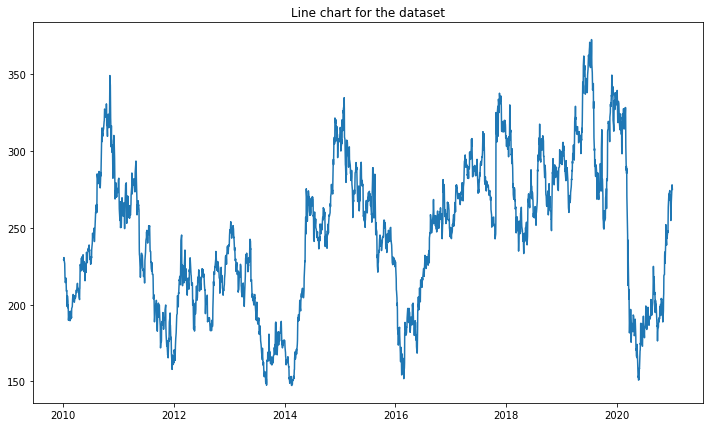

In [10]:
plt.figure(figsize=(12, 7))
plt.title('Line chart for the dataset')
plt.plot(df['Close'])

Splitting dataset into training and testing datset and filtering columns

In [11]:
train = df[df.index<='2019-12-31']

In [12]:
train.drop(['Open', 'High', 'Low', 'Volume', 'Currency'], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
train.head()

,Close
Date,
2010-01-04,229.12
2010-01-05,229.21
2010-01-06,230.58
2010-01-07,229.29
2010-01-08,228.60


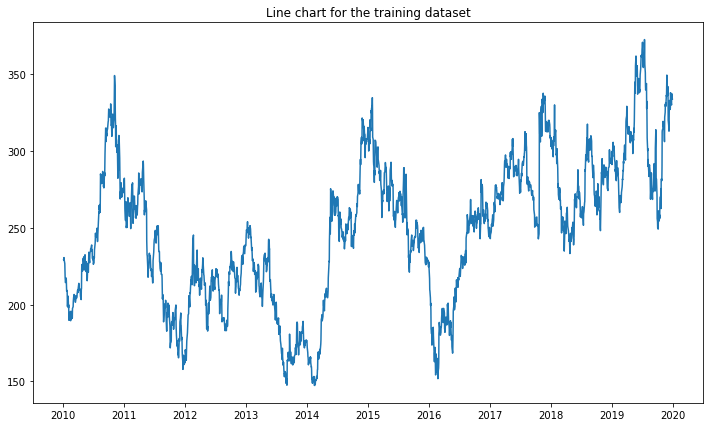

In [14]:
plt.figure(figsize=(12, 7))
plt.title('Line chart for the training dataset')
plt.plot(train)

In [15]:
test = df[df.index>'2019-12-31']

In [16]:
test.drop(['Open', 'High', 'Low', 'Volume', 'Currency'], axis = 1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [17]:
test.head()

,Close
Date,
2020-01-01,334.45
2020-01-02,339.30
2020-01-03,333.70
2020-01-06,319.00
2020-01-07,318.40


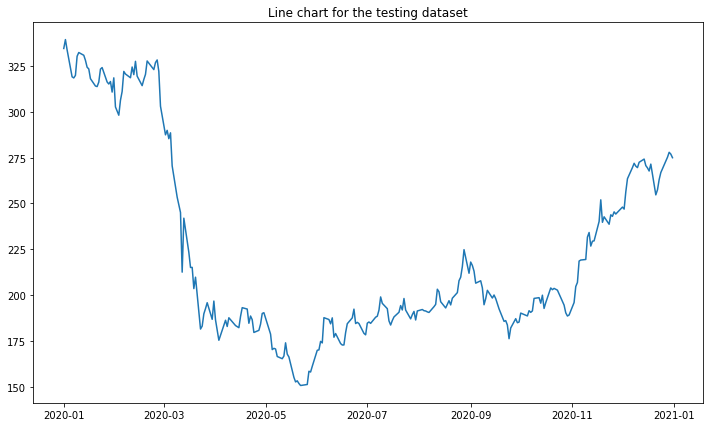

In [18]:
plt.figure(figsize=(12, 7))
plt.title('Line chart for the testing dataset')
plt.plot(test)

Scaling Dataset as LSTM is highly affected by scale of data

In [19]:
scaler_train = preprocessing.MinMaxScaler()
train_df = scaler_train.fit_transform(train)
train_df = pd.DataFrame(train_df, columns=['Close'], index=train.index)
train_df.head()

,Close
Date,
2010-01-04,0.363313
2010-01-05,0.363713
2010-01-06,0.369801
2010-01-07,0.364069
2010-01-08,0.361002


In [20]:
scaler_test = preprocessing.MinMaxScaler()
test_df = scaler_test.fit_transform(test)
test_df = pd.DataFrame(test_df, columns=['Close'], index=test.index)
test_df.head()

,Close
Date,
2020-01-01,0.974264
2020-01-02,1.000000
2020-01-03,0.970284
2020-01-06,0.892279
2020-01-07,0.889095


Creating Dataframes for building LSTM model with time_step = 30 days (i.e., it will use past 30 days data to predict output)

In [21]:
#function to create dataset
def create_dataset(dataset, time_step=30):
  dataX = pd.DataFrame()
  dataY = pd.DataFrame()
  X = []
  Y = []
  for i in range(len(dataset)-time_step-1):
    a = dataset.iloc[i:(i+time_step)].to_numpy().reshape(-1)
    X.append(a)
    Y.append(dataset.iloc[i + time_step].to_numpy().reshape(-1))
  return dataX.append(X), dataY.append(Y)

In [22]:
time_step = 30
x_train, y_train = create_dataset(train_df, time_step)
x_test, y_test = create_dataset(test_df, time_step)

In [23]:
print("Shape of x_train", x_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of x_test", x_test.shape)
print("Shape of y_test", y_test.shape)

Shape of x_train (2447, 30)
Shape of y_train (2447, 1)
Shape of x_test (221, 30)
Shape of y_test (221, 1)


In [24]:
x_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.363313,0.363713,0.369801,0.364069,0.361002,0.352648,0.324209,0.312078,0.303857,0.297636,0.303413,0.310834,0.304968,0.289060,0.272752,0.274618,0.228404,0.235336,0.259065,0.243335,0.224316,0.233381,0.210763,0.188500,0.195032,0.205741,0.211829,0.194765,0.197298,0.187256
1,0.363713,0.369801,0.364069,0.361002,0.352648,0.324209,0.312078,0.303857,0.297636,0.303413,0.310834,0.304968,0.289060,0.272752,0.274618,0.228404,0.235336,0.259065,0.243335,0.224316,0.233381,0.210763,0.188500,0.195032,0.205741,0.211829,0.194765,0.197298,0.187256,0.198631
2,0.369801,0.364069,0.361002,0.352648,0.324209,0.312078,0.303857,0.297636,0.303413,0.310834,0.304968,0.289060,0.272752,0.274618,0.228404,0.235336,0.259065,0.243335,0.224316,0.233381,0.210763,0.188500,0.195032,0.205741,0.211829,0.194765,0.197298,0.187256,0.198631,0.214762
3,0.364069,0.361002,0.352648,0.324209,0.312078,0.303857,0.297636,0.303413,0.310834,0.304968,0.289060,0.272752,0.274618,0.228404,0.235336,0.259065,0.243335,0.224316,0.233381,0.210763,0.188500,0.195032,0.205741,0.211829,0.194765,0.197298,0.187256,0.198631,0.214762,0.208319
4,0.361002,0.352648,0.324209,0.312078,0.303857,0.297636,0.303413,0.310834,0.304968,0.289060,0.272752,0.274618,0.228404,0.235336,0.259065,0.243335,0.224316,0.233381,0.210763,0.188500,0.195032,0.205741,0.211829,0.194765,0.197298,0.187256,0.198631,0.214762,0.208319,0.191833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2442,0.749378,0.759376,0.708496,0.704941,0.775595,0.789815,0.813367,0.806257,0.817588,0.808478,0.838695,0.836029,0.871801,0.897352,0.864246,0.849360,0.839362,0.864246,0.839140,0.767153,0.752488,0.737824,0.735158,0.775373,0.822920,0.819810,0.824476,0.798036,0.803368,0.846472
2443,0.759376,0.708496,0.704941,0.775595,0.789815,0.813367,0.806257,0.817588,0.808478,0.838695,0.836029,0.871801,0.897352,0.864246,0.849360,0.839362,0.864246,0.839140,0.767153,0.752488,0.737824,0.735158,0.775373,0.822920,0.819810,0.824476,0.798036,0.803368,0.846472,0.822254
2444,0.708496,0.704941,0.775595,0.789815,0.813367,0.806257,0.817588,0.808478,0.838695,0.836029,0.871801,0.897352,0.864246,0.849360,0.839362,0.864246,0.839140,0.767153,0.752488,0.737824,0.735158,0.775373,0.822920,0.819810,0.824476,0.798036,0.803368,0.846472,0.822254,0.818032
2445,0.704941,0.775595,0.789815,0.813367,0.806257,0.817588,0.808478,0.838695,0.836029,0.871801,0.897352,0.864246,0.849360,0.839362,0.864246,0.839140,0.767153,0.752488,0.737824,0.735158,0.775373,0.822920,0.819810,0.824476,0.798036,0.803368,0.846472,0.822254,0.818032,0.810923


In [25]:
y_train

,0
0,0.198631
1,0.214762
2,0.208319
3,0.191833
4,0.196721
...,...
2442,0.822254
2443,0.818032
2444,0.810923
2445,0.843806


In [26]:
x_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.974264,1.000000,0.970284,0.892279,0.889095,0.896524,0.951711,0.962590,0.954630,0.940037,0.920138,0.915097,0.886973,0.865747,0.864155,0.877156,0.914566,0.919077,0.877421,0.871584,0.878748,0.848236,0.889361,0.805253,0.781374,0.824622,0.849828,0.907933,0.900504,0.889626
1,1.000000,0.970284,0.892279,0.889095,0.896524,0.951711,0.962590,0.954630,0.940037,0.920138,0.915097,0.886973,0.865747,0.864155,0.877156,0.914566,0.919077,0.877421,0.871584,0.878748,0.848236,0.889361,0.805253,0.781374,0.824622,0.849828,0.907933,0.900504,0.889626,0.920669
2,0.970284,0.892279,0.889095,0.896524,0.951711,0.962590,0.954630,0.940037,0.920138,0.915097,0.886973,0.865747,0.864155,0.877156,0.914566,0.919077,0.877421,0.871584,0.878748,0.848236,0.889361,0.805253,0.781374,0.824622,0.849828,0.907933,0.900504,0.889626,0.920669,0.898647
3,0.892279,0.889095,0.896524,0.951711,0.962590,0.954630,0.940037,0.920138,0.915097,0.886973,0.865747,0.864155,0.877156,0.914566,0.919077,0.877421,0.871584,0.878748,0.848236,0.889361,0.805253,0.781374,0.824622,0.849828,0.907933,0.900504,0.889626,0.920669,0.898647,0.937119
4,0.889095,0.896524,0.951711,0.962590,0.954630,0.940037,0.920138,0.915097,0.886973,0.865747,0.864155,0.877156,0.914566,0.919077,0.877421,0.871584,0.878748,0.848236,0.889361,0.805253,0.781374,0.824622,0.849828,0.907933,0.900504,0.889626,0.920669,0.898647,0.937119,0.894402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,0.429026,0.442292,0.403025,0.417087,0.418148,0.474131,0.536747,0.471743,0.487663,0.466171,0.493500,0.488989,0.501990,0.495622,0.515787,0.509950,0.559565,0.597771,0.630141,0.642345,0.634120,0.629875,0.645264,0.654550,0.635712,0.629079,0.620058,0.639958,0.551075,0.565667
217,0.442292,0.403025,0.417087,0.418148,0.474131,0.536747,0.471743,0.487663,0.466171,0.493500,0.488989,0.501990,0.495622,0.515787,0.509950,0.559565,0.597771,0.630141,0.642345,0.634120,0.629875,0.645264,0.654550,0.635712,0.629079,0.620058,0.639958,0.551075,0.565667,0.595118
218,0.403025,0.417087,0.418148,0.474131,0.536747,0.471743,0.487663,0.466171,0.493500,0.488989,0.501990,0.495622,0.515787,0.509950,0.559565,0.597771,0.630141,0.642345,0.634120,0.629875,0.645264,0.654550,0.635712,0.629079,0.620058,0.639958,0.551075,0.565667,0.595118,0.615548
219,0.417087,0.418148,0.474131,0.536747,0.471743,0.487663,0.466171,0.493500,0.488989,0.501990,0.495622,0.515787,0.509950,0.559565,0.597771,0.630141,0.642345,0.634120,0.629875,0.645264,0.654550,0.635712,0.629079,0.620058,0.639958,0.551075,0.565667,0.595118,0.615548,0.659857


In [27]:
y_test

,0
0,0.920669
1,0.898647
2,0.937119
3,0.894402
4,0.866808
...,...
216,0.595118
217,0.615548
218,0.659857
219,0.674184


Builiding LSTM Model

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
x_train =x_train.to_numpy().reshape(x_train.shape[0],x_train.shape[1] , 1)
x_test = x_test.to_numpy().reshape(x_test.shape[0],x_test.shape[1] , 1)

In [29]:
model=Sequential()
model.add(LSTM(15,return_sequences=True,input_shape=(30,1)))
model.add(LSTM(15,return_sequences=True))
model.add(LSTM(15))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 15)            1020      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 15)            1860      
_________________________________________________________________
lstm_2 (LSTM)                (None, 15)                1860      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 4,756
Trainable params: 4,756
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(x_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
39/39 [==============================] - 6s 8ms/step - loss: 0.0895
Epoch 2/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0080
Epoch 3/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0048
Epoch 4/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0044
Epoch 5/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0041
Epoch 6/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0037
Epoch 7/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0033
Epoch 8/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 9/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 10/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 11/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0025
Epoch 12/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 13/100
39/39 [=================

Prediction

In [32]:
test_predict=model.predict(x_test)

In [33]:
### Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_test,test_predict))

0.03622563300398249

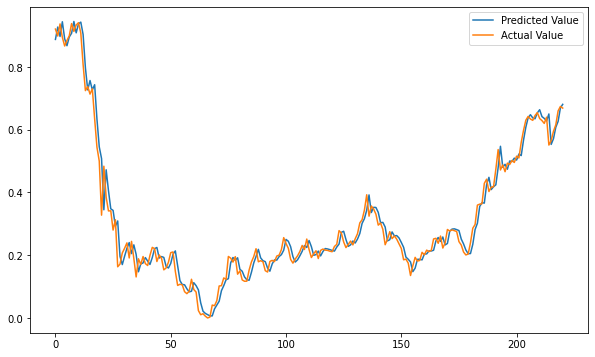

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(test_predict, label='Predicted Value')
plt.plot(y_test, label='Actual Value')
plt.legend()

In [35]:
#perform inverse transform to bring data back to its original scale
predict=scaler_test.inverse_transform(test_predict)
actual=scaler_test.inverse_transform(y_test)

In [36]:
### Calculate RMSE performance metrics for actual range values
math.sqrt(mean_squared_error(actual, predict))

6.826720270200339

Text(0.5, 1.0, 'Line plot between predicted and actual value')

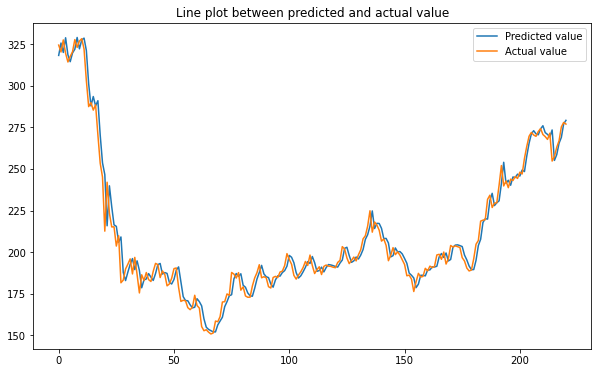

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(predict, label='Predicted value')
plt.plot(actual, label='Actual value')
plt.legend()
plt.title('Line plot between predicted and actual value')